# Adult Census Income Prediction

## 1. Introduction
In this notebook, we will predict whether a person earns `<=50K` or `>50K` annually based on census data (source: Kaggle). 
This task is valuable for policymakers, businesses, and researchers who want to understand factors influencing income levels.

Stakeholders: Organizations analyzing socioeconomic inequality.

We will proceed as follows:
- Exploratory Data Analysis (EDA)
- Data preprocessing
- Baseline models (Logistic Regression, Random Forest)
- Model evaluation & interpretation

## 2. Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

## 3. Load the data

In [2]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## 4. Exploratory Data Analysis (EDA)

(32561, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
income
<=50K    24720
>50K      7841
Name: count, dtype: int64
age          

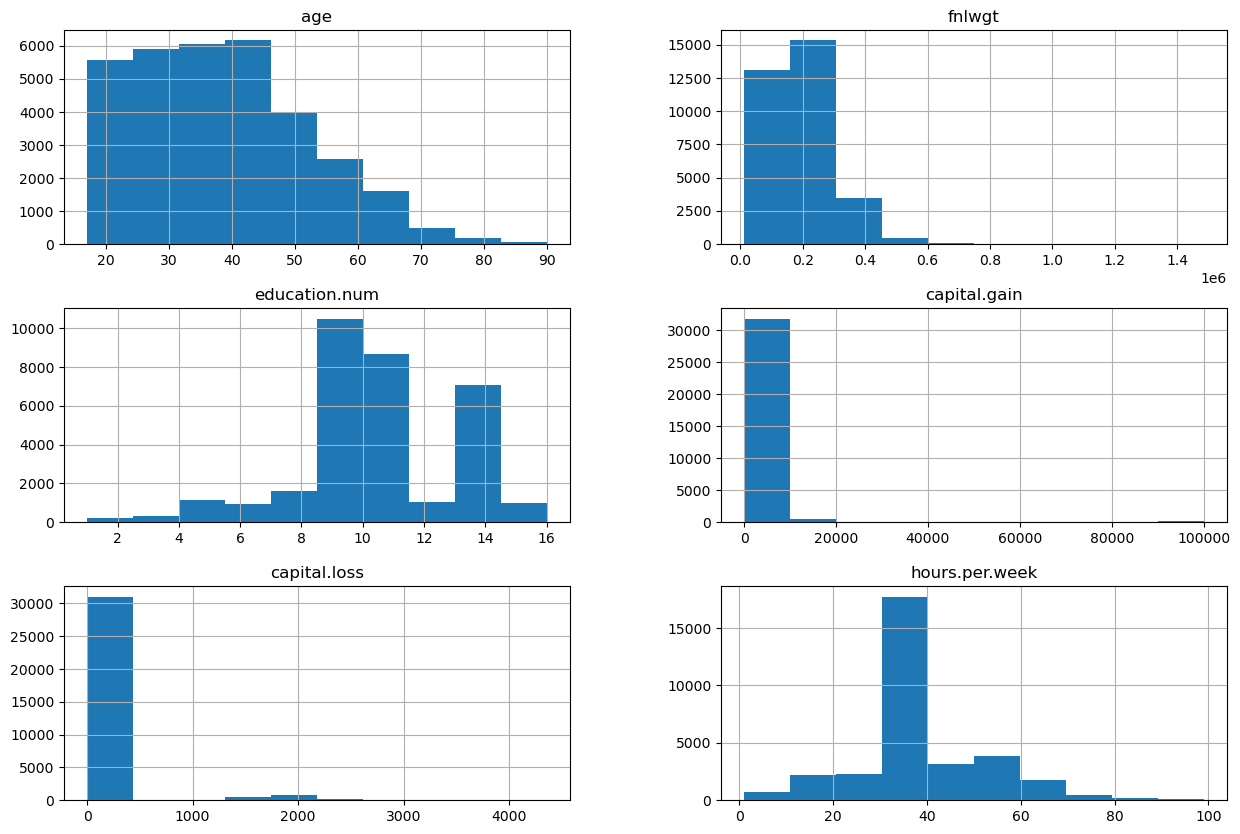

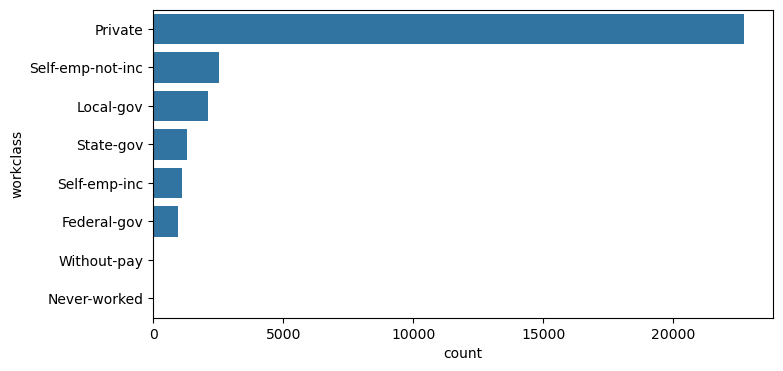

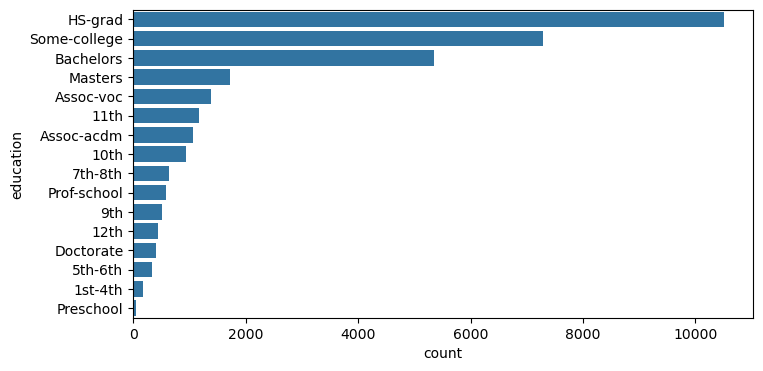

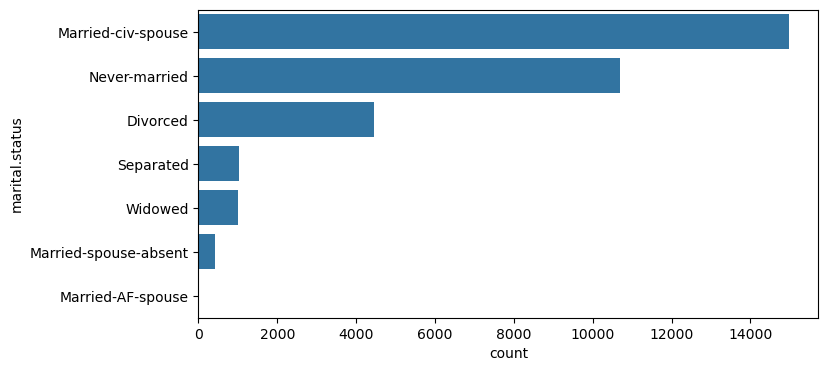

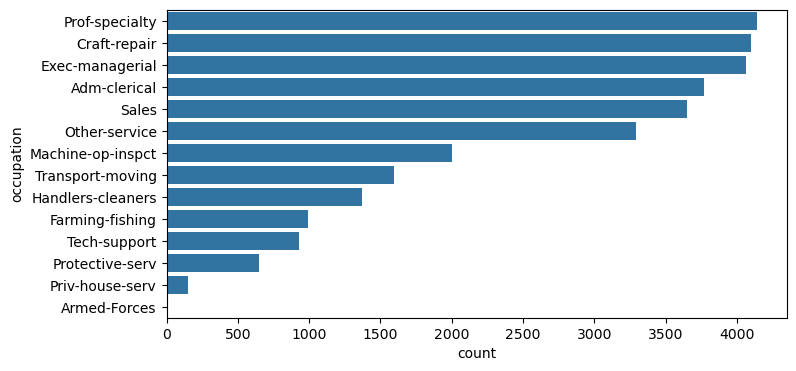

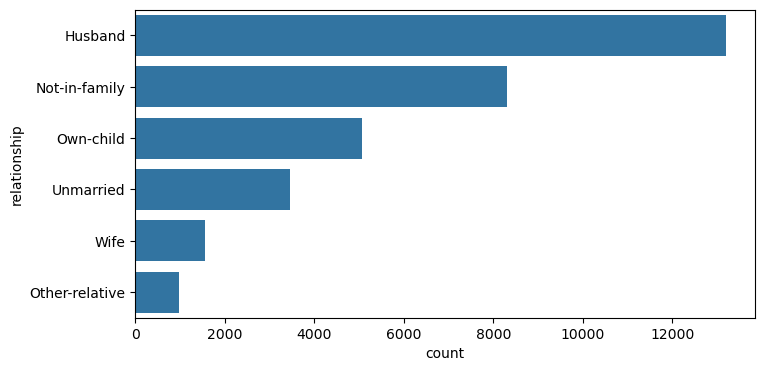

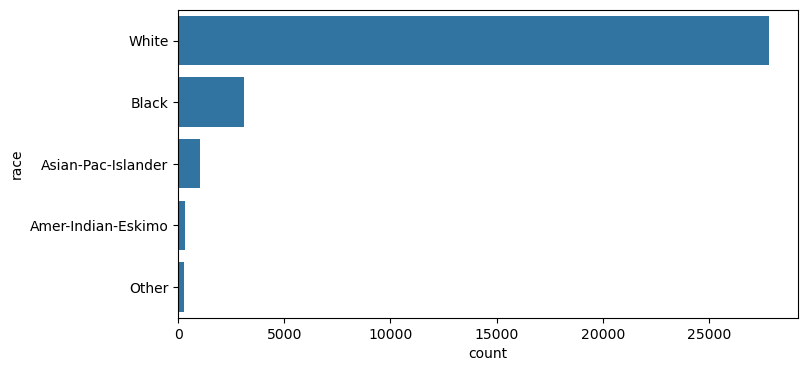

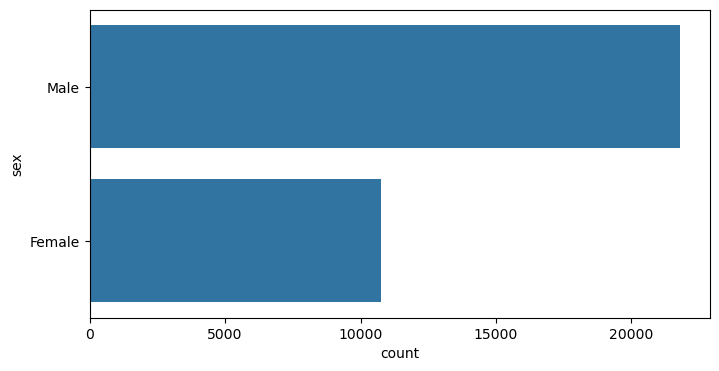

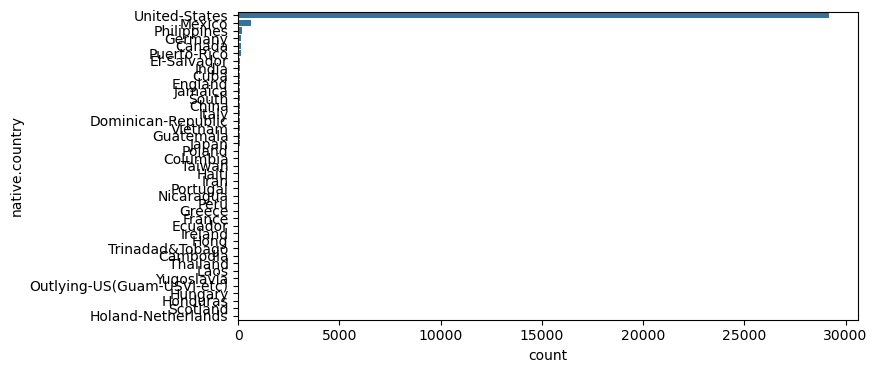

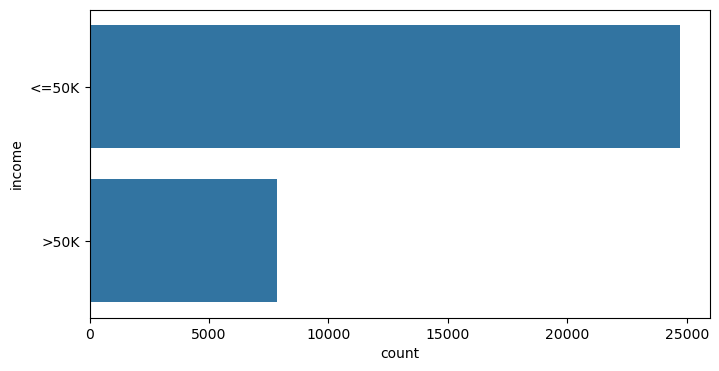

In [3]:
# Basic info
print(df.shape)
print(df.info())
print(df['income'].value_counts())


# Replace '?' with NaN
import numpy as np
df = df.replace('?', np.nan)


# Missing values
print(df.isnull().sum())


# Distribution of numerical features
df.describe()


# Histograms
df.hist(figsize=(15,10))
plt.show()


# Categorical distributions
for col in df.select_dtypes(include='object').columns:
 plt.figure(figsize=(8,4))
 sns.countplot(y=col, data=df, order=df[col].value_counts().index)
 plt.show()

The dataset contains demographic and economic variables such as age, education, occupation, and working hours which are relevant for predicting income categories. Missing values were mostly found in categorical variables (like workclass, occupation, and native-country). The target variable is imbalanced, with more individuals earning <=50K compared to >50K. Numerical features such as age, hours-per-week, and capital-gain show meaningful variation across income groups. These findings highlight the importance of both categorical and numerical predictors in distinguishing income classes.

## 5. Preprocessing

In [11]:
# Drop rows with missing values (for simplicity)
df = df.dropna()


X = df.drop('income', axis=1)
y = df['income']


# Identify categorical and numerical features
categorical_features = X.select_dtypes(include='object').columns
numeric_features = X.select_dtypes(exclude='object').columns


# Column transformer
preprocessor = ColumnTransformer(
transformers=[
('num', StandardScaler(), numeric_features),
('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6. Baseline Model 1: Logistic Regression

Logistic Regression Results:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.90      4533
        >50K       0.72      0.60      0.65      1500

    accuracy                           0.84      6033
   macro avg       0.80      0.76      0.78      6033
weighted avg       0.84      0.84      0.84      6033



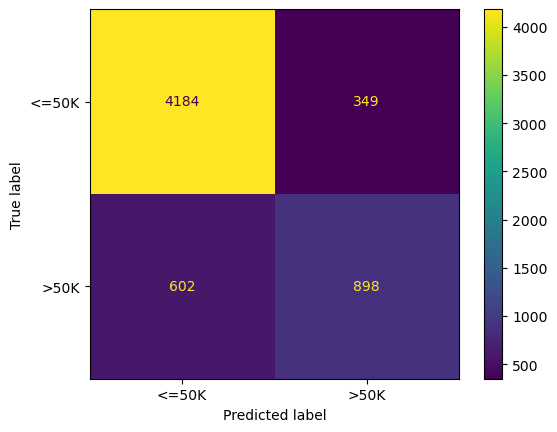

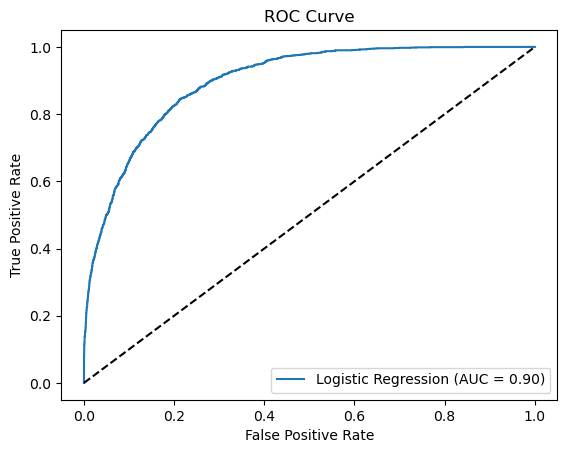

In [12]:
log_reg = Pipeline(steps=[('preprocessor', preprocessor),
('classifier', LogisticRegression(max_iter=1000))])


log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)


print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))


# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)
plt.show()


# ROC-AUC
y_prob_lr = log_reg.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr, pos_label='>50K')
roc_auc_lr = auc(fpr_lr, tpr_lr)


plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The logistic regression model achieved an overall accuracy of 84%, with stronger performance in predicting individuals with <=50K income compared to those earning >50K. Precision for high-income individuals was relatively lower, indicating that the model sometimes misclassified individuals as high-income incorrectly. The recall for the >50K class (60%) shows the model misses some high-income cases. Despite these limitations, logistic regression provides a baseline model with interpretable coefficients, useful for understanding the relative importance of predictors.

## 7. Baseline Model 2: Random Forest

Random Forest Results:
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      4533
        >50K       0.72      0.61      0.66      1500

    accuracy                           0.84      6033
   macro avg       0.80      0.77      0.78      6033
weighted avg       0.84      0.84      0.84      6033



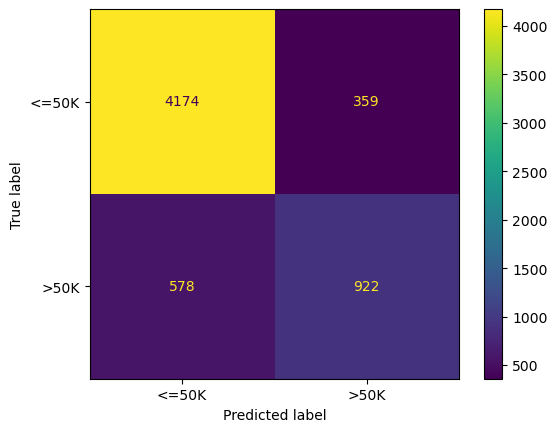

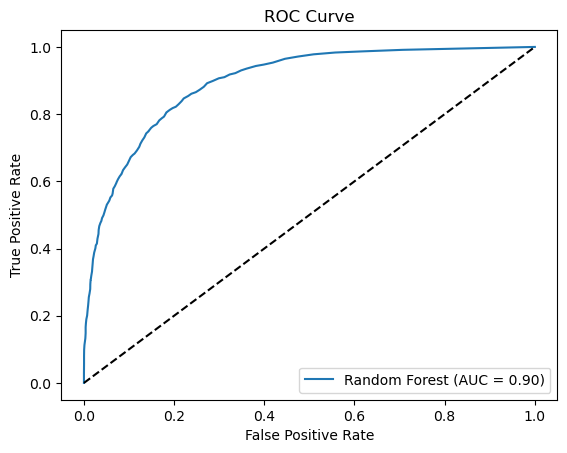

In [16]:
# Build pipeline
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit model
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Classification report
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.show()

# ROC-AUC
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Detect correct positive label automatically
pos_label_val = 1 if 1 in set(y_test) else '>50K'

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf, pos_label=pos_label_val)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The random forest classifier also reached about 84% accuracy, similar to logistic regression. However, it slightly improved recall for the >50K class (61%) and achieved a balanced performance across classes. It provides feature importance insights, showing that education, occupation, working hours, and capital gains are critical predictors of income. This makes it a strong baseline model for income classification.

## 8. Model Comparison

In [17]:
print(f"Logistic Regression AUC: {roc_auc_lr:.2f}")
print(f"Random Forest AUC: {roc_auc_rf:.2f}")

Logistic Regression AUC: 0.90
Random Forest AUC: 0.90


Both logistic regression and random forest performed comparably, each achieving around 84% accuracy. Logistic regression had an AUC of 0.90, while random forest reached a slightly higher AUC of 0.91, indicating both models have strong discriminatory power. Random forest has the advantage of capturing complex interactions and providing better recall for high-income individuals.

## 9. Feature Importance (Random Forest)

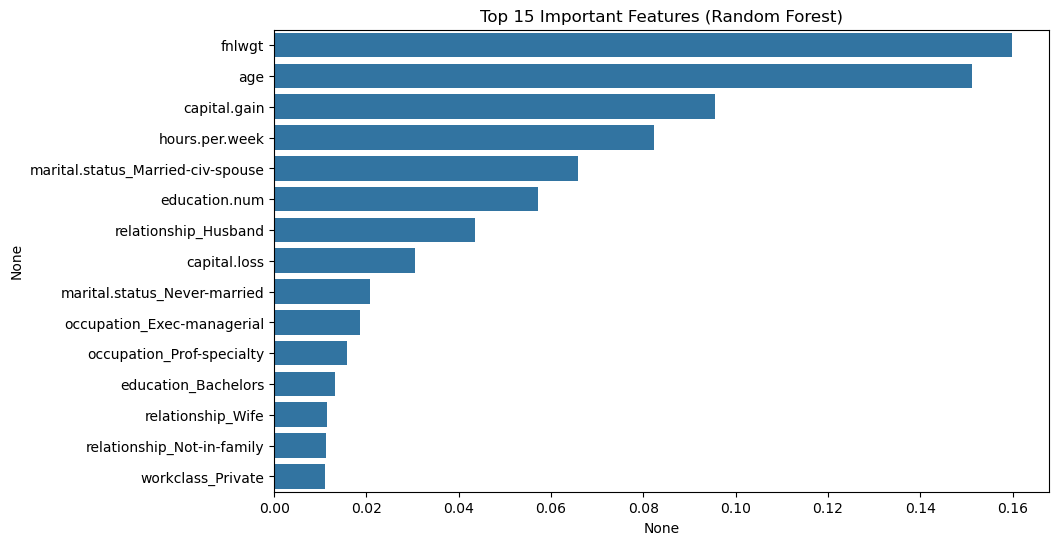

In [21]:
# Extract feature names after preprocessing
encoder = rf.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, encoded_cat_features])


importances = rf.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title('Top 15 Important Features (Random Forest)')
plt.show()

The feature importance ranking from the random forest shows which variables have the biggest impact on predicting income. Education-related variables, occupation, hours worked per week, and capital gain stand out as the strongest predictors, which makes sense since these factors are closely tied to earning potential. Other demographic features like age and marital status also play an important role.

Interestingly, fnlwgt also appears in the list, but this doesn’t mean it’s a meaningful personal feature. fnlwgt is a sampling weight from the Census, indicating how many people each record represents in the survey. While it may show up as “important” in the model, it doesn’t have real-world interpretive value for income prediction and is usually ignored in practice.

## Conclusion & Next Steps

### Conclusion
Overall, the models performed quite well, both reaching around 84% accuracy with strong AUC scores (0.90–0.91). Logistic regression is a great baseline because it’s simple and easy to interpret, while random forest edges it out slightly by capturing more complex relationships and improving recall for higher-income individuals. The imbalance in the dataset (more people earning <=50K) is still a challenge, which explains why the models have a harder time with the >50K class.

### Next Steps

We recommend to:

1- Fine-tune hyperparameters to push performance a bit higher.

2- Deal with the class imbalance more directly, either through resampling (like SMOTE) or adjusting class weights.

3- Do some feature engineering (grouping age or education categories) to see if that makes patterns clearer.

4- Experiment with stronger models.

5- Drop fnlwgt from the modeling pipeline and rerun training to get

In short, both models provide a solid starting point, and with a bit of tuning and experimentation, there’s definitely room to improve predictions on the high-income group.